# Neural Message Passing

To discover a proficient variant of supervised learning methodologies in molecular applications and to apply it to chemical prediction benchmarks, Gilmer et al. (2017) have proposed a reformulation of prevailing neural network models that are invariant to molecular symmetries within a framework termed as Message Passing Neural Networks (MPNNs).

MPNNs' forward pass comprises a message passing phase and a readout phase. The message passing phase is executed for a specific number of time steps $T$. Given an undirected graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ with a set of node features $\textbf{X} \in \mathbb{R}^{d \times |\mathcal{V}|}$ and a set of edge features $\textbf{E} \in \mathbb{R}^{d \times |\mathcal{V}| \times |\mathcal{V'}|}$, the authors define the message at the $t^{\text{th}}$ message passing phase as follows:

\begin{align*}
    m_u^{(t)} &= \sum_{v \in \mathcal{N}(u)} \textbf{M}^{(t-1)} \left( h^{(t-1)}_u, h^{(t-1)}_v, \textbf{E}_{uv} \right) \\
    h^{(t)}_u &= \textbf{U}_t \left( h^{(t-1)}_u, m_u^{(t-1)} \right) \\
\end{align*}

where

- for each node $u \in \mathcal{V}$, $v \in \mathcal{N}(u)$ and $\mathcal{N}(u)$ is the set of neighbourhood nodes of $u$
- $\textbf{M}^{(t)}$ is the message function at $t^{\text{th}}$ phase
- $h^{(t)}_v$ is the hidden states
- $\textbf{U}^{(t)}$ is the vertex update function
- Here, $\textbf{M}$, $\textbf{U}$, $\textbf{R}$ are all learned differentiable functions.

Given some readout function $\textbf{R}$, the readout phase computes a feature vector for $\mathcal{G}$ is given by

$$
\hat{y} = \textbf{R} \left( \left\{ h_u^{(T)} | u \in \mathcal{\mathcal{V}} \right\} \right)
$$

In [1]:
import sys

sys.path.insert(0, '..')

In [3]:
from data.dataset import Dataset
from data.featurization.dgl_Graph import DGL_Graph
from model.abstractmodel import AbstractModel
import torch
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST = Dataset.load_csv("ds/TST")

In [5]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [6]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [11]:
from model.dgl.MPNN import MPNN

num_heads = 5
AbstractModel.set_seed(2387)

k_pred_tst1 = []

for trn, val in zip(trn_sets, val_sets):
    model = MPNN(
        task_type="regression",
        # MPNN Configuration
        n_tasks=1,
        node_in_feats=featurizer.get_node_feat_size(),
        edge_in_feats=featurizer.get_edge_feat_size(),
        node_out_feats=63,
        edge_hidden_feats=56,
        num_step_message_passing=2,
        num_step_set2set=8,
        num_layer_set2set=5,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.008810928673332262,
        batch_size=1024
    )
    model.fit(trn, val=val, epochs=1100, min_epoch=900, early_stop=20)
    k_pred_tst1.append(model.predict(TST).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 86%|████████▌ | 946/1100 [01:59<00:19,  7.95it/s, loss: 0.170 rmse: 1.130]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 84%|████████▍ | 927/1100 [01:56<00:21,  7.96it/s, loss: 0.237 rmse: 0.759]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 85%|████████▍ | 931/1100 [01:47<00:19,  8.70it/s, loss: 0.228 rmse: 0.821]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 85%|████████▍ | 934/1100 [01:41<00:18,  9.19it/s, loss: 0.219 rmse: 0.880]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 87%|████████▋ | 955/1100 [01:52<00:17,  8.47it/s, loss: 0.234 rmse: 0.785]


In [12]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]

In [13]:
print(f"TST : RMSE {mean_squared_error(TST.y, pred_tst1, squared=False)}")
print(f"TST : R^2 {r2_score(TST.y, pred_tst1)}")

TST : RMSE 1.0240721856487147
TST : R^2 0.4307092779123931


Text(0.5, 1.0, '2008 Solubility Challenge Test Set (MPNN)\nRMSE: 1.024, $R^2$: 0.431')

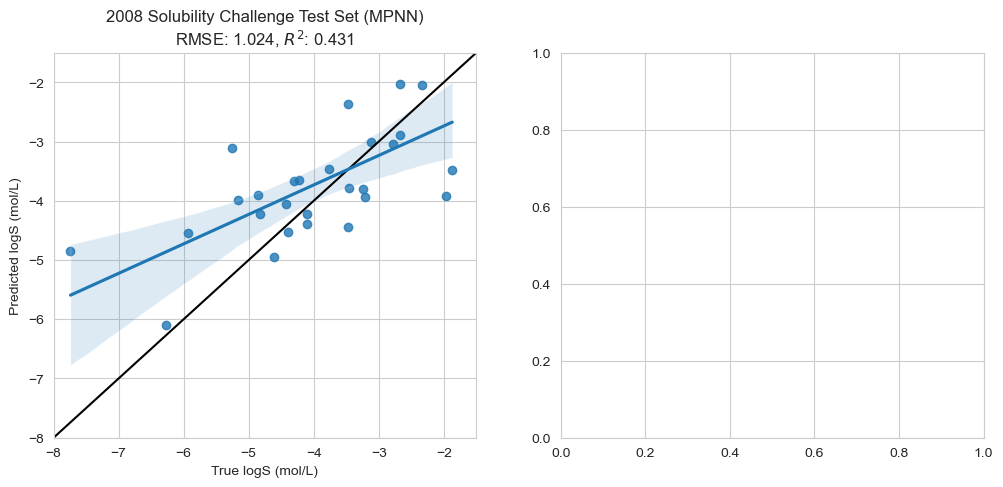

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "MPNN"
min_ax1, max_ax1 = -8, -1.5

fig, (ax1, _) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)

ax1.set_title(f"2008 Solubility Challenge Test Set ({model_name})\n"
              f"RMSE: {mean_squared_error(TST.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST.y, pred_tst1):.3f}")